# Importing the Dataset

In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_df = pd.read_parquet("hf://datasets/mediabiasgroup/BABE/" + splits["train"])
test_df = pd.read_parquet("hf://datasets/mediabiasgroup/BABE/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE


In [ ]:
train_df.head()

,text,news_link,label,outlet,topic,type,label_opinion,biased_words,uuid
0,NYPD Commissioner Dermot Shea on Monday expres...,http://feedproxy.google.com/~r/breitbart/~3/F5...,0,Breitbart,marriage-equality,None,Entirely factual,[],GtvFWZmmQmybyeMnb8Wbsr
1,School systems across the country are adopting...,https://thefederalist.com/2020/07/08/black-liv...,1,Federalist,islam,None,Expresses writer’s opinion,"['indoctrinating', 'Marxist', 'alarming']",mvoQPtabs6NZbby6LkLbms
2,"And then along came President Barry Obama, who...",http://feedproxy.google.com/~r/breitbart/~3/ks...,1,Breitbart,marriage-equality,None,Expresses writer’s opinion,"['what', 'the', 'hell']",RDWPbijx3n2aw6NiMHt7di
3,"The curfews, which have never before occurred ...",https://www.alternet.org/2020/06/we-just-got-a...,1,Alternet,elections-2020,left,Entirely factual,"['false', 'claims']",2uYKw5KpXasJWH65WCjSu4
4,"Rather than help be a part of the solution, Tr...",https://www.alternet.org/2020/06/trump-thought...,1,Alternet,elections-2020,left,Expresses writer’s opinion,['racist'],SRGvrzY9PkvtHESdts35Rw


In [ ]:
test_df.head()

,text,news_link,label,outlet,topic,type,label_opinion,biased_words,uuid
0,"As the Black Lives Matter movement grows, comp...",https://www.foxnews.com/us/juneteenth-calls-in...,0,Fox News,marriage-equality,None,Entirely factual,[],ayLcFCbNshSG5zjdXTQHGH
1,The case of Rahaf Mohammed al-Qunun drawn new ...,https://www.reuters.com/article/us-thailand-sa...,0,Reuters,gender,center,Entirely factual,[],4QADvLi4RqLNtzkM9rCmS3
2,The Post said the talks on payroll taxes were ...,https://www.reuters.com/article/us-usa-economy...,0,Reuters,taxes,center,Entirely factual,[],nAprfpSfXPNX3WvMFvADd7
3,Nearly 78 percent of Americans report experien...,https://www.thedailybeast.com/climate-disaster...,0,The Daily Beast,environment,None,None,None,yQsHy6FPz5cq92SE22Rwhj
4,Colin P. Clarke has been teaching a course on ...,https://eu.usatoday.com/story/news/nation/2020...,0,USA Today,white-nationalism,center,Entirely factual,[],h4qCzqXRwgh5JyVBykCJFv


In [ ]:
label_mapping = {"right": 0, "left": 1, "center": 2}
# Remove None values in 'type' column
train_df = train_df.dropna(subset=['type']).copy()
test_df = test_df.dropna(subset=['type']).copy()
train_df.loc[:, 'type'] = train_df['type'].map(label_mapping).astype(int)
test_df.loc[:, 'type'] = test_df['type'].map(label_mapping).astype(int)

In [ ]:
train_df.shape

(2026, 9)

In [ ]:
test_df.shape

(646, 9)

# Baseline - Bert Classification Model

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

text_column = 'text'
label_column = 'type'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df[label_column].unique()))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(train_df['text'], train_df['type'], tokenizer)
test_dataset = NewsDataset(test_df['text'], test_df['type'], tokenizer)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def objective(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=3,
        hidden_dropout_prob=dropout_rate  
    ).to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(2):  
        for batch in tqdm(train_loader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch.values()]
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch.values()]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(true_labels, preds)
    return 1 - val_accuracy 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)

[I 2024-12-06 14:26:12,231] A new study created in memory with name: no-name-037370ab-3210-4920-aae8-7107fbba6775


Using device: cuda


<ipython-input-10-afcee4b7dd4a>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
<ipython-input-10-afcee4b7dd4a>:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementati

Best hyperparameters: {'learning_rate': 6.777367974128277e-05, 'batch_size': 32, 'dropout_rate': 0.14974202257253255}


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from transformers import AdamW, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

learning_rate = 6.777367974128277e-05  # Best trial value
batch_size = 32  # Best trial value
dropout_rate = 0.14974202257253255  # Best trial value

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    hidden_dropout_prob=dropout_rate
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

optimizer = AdamW(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    print("GPU is available!")
    print(torch.cuda.get_device_name(0))
else:
    print("GPU not available, using CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

epochs = 7
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    all_labels = []
    all_preds = []

    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch["input_ids"], batch["attention_mask"], batch["labels"]
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device, dtype=torch.long),
        )

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    avg_epoch_loss = epoch_loss / len(train_loader)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Average loss after epoch {epoch + 1}: {avg_epoch_loss:.4f}")
    print(f"Accuracy after epoch {epoch + 1}: {accuracy:.4f}")
    print(f"Precision after epoch {epoch + 1}: {precision:.4f}")
    print(f"Recall after epoch {epoch + 1}: {recall:.4f}")
    print(f"F1 Score after epoch {epoch + 1}: {f1:.4f}")

model.save_pretrained("/content/gdrive/MyDrive/266_Project/BERT_Baseline/fine_tuned_model")
tokenizer.save_pretrained("/content/gdrive/MyDrive/266_Project/BERT_Baseline/fine_tuned_model")
print("Model and tokenizer saved successfully!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


GPU is available!
Tesla T4
Using device: cuda
Epoch 1/7


100%|██████████| 64/64 [00:44<00:00,  1.43it/s]


Average loss after epoch 1: 1.0545
Accuracy after epoch 1: 0.4220
Precision after epoch 1: 0.4398
Recall after epoch 1: 0.4220
F1 Score after epoch 1: 0.4085
Epoch 2/7


100%|██████████| 64/64 [00:43<00:00,  1.49it/s]


Average loss after epoch 2: 0.8526
Accuracy after epoch 2: 0.5918
Precision after epoch 2: 0.5911
Recall after epoch 2: 0.5918
F1 Score after epoch 2: 0.5912
Epoch 3/7


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Average loss after epoch 3: 0.5135
Accuracy after epoch 3: 0.7962
Precision after epoch 3: 0.7956
Recall after epoch 3: 0.7962
F1 Score after epoch 3: 0.7958
Epoch 4/7


100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Average loss after epoch 4: 0.2442
Accuracy after epoch 4: 0.9102
Precision after epoch 4: 0.9100
Recall after epoch 4: 0.9102
F1 Score after epoch 4: 0.9101
Epoch 5/7


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Average loss after epoch 5: 0.1283
Accuracy after epoch 5: 0.9595
Precision after epoch 5: 0.9596
Recall after epoch 5: 0.9595
F1 Score after epoch 5: 0.9595
Epoch 6/7


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]


Average loss after epoch 6: 0.0594
Accuracy after epoch 6: 0.9788
Precision after epoch 6: 0.9788
Recall after epoch 6: 0.9788
F1 Score after epoch 6: 0.9788
Epoch 7/7


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]


Average loss after epoch 7: 0.0306
Accuracy after epoch 7: 0.9901
Precision after epoch 7: 0.9902
Recall after epoch 7: 0.9901
F1 Score after epoch 7: 0.9901
Model and tokenizer saved successfully!


### Test Dataset

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

model.eval()

all_preds_test = []
all_labels_test = []
all_texts_test = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch["input_ids"], batch["attention_mask"], batch["labels"]
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device, dtype=torch.long),
        )

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())
        all_texts_test.extend(tokenizer.batch_decode(input_ids, skip_special_tokens=True))

test_accuracy = accuracy_score(all_labels_test, all_preds_test)
test_precision = precision_score(all_labels_test, all_preds_test, average="weighted")
test_recall = recall_score(all_labels_test, all_preds_test, average="weighted")
test_f1 = f1_score(all_labels_test, all_preds_test, average="weighted")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.6207
Test Precision: 0.6633
Test Recall: 0.6207
Test F1 Score: 0.6069


### Confusion matrix

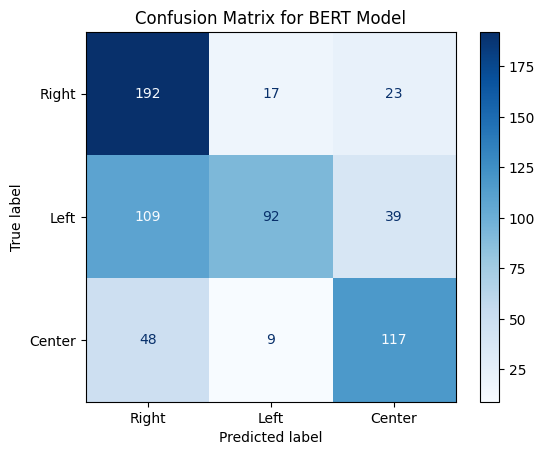

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels_test, all_preds_test)

class_labels = ["Right", "Left", "Center"]  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for BERT Model")
plt.show()

In [ ]:
import numpy as np
all_preds_test = np.array(all_preds_test)
all_labels_test = np.array(all_labels_test)

print("\nCorrect Predictions:")
correct_indices = np.where(all_preds_test == all_labels_test)[0]
for i in correct_indices[:5]: 
    print(f"Text: {all_texts_test[i]}")
    print(f"True Label: {all_labels_test[i]}, Predicted Label: {all_preds_test[i]}")
    print("------")

print("\nIncorrect Predictions:")
incorrect_indices = np.where(all_preds_test != all_labels_test)[0]
for i in incorrect_indices[:5]:  
    print(f"Text: {all_texts_test[i]}")
    print(f"True Label: {all_labels_test[i]}, Predicted Label: {all_preds_test[i]}")
    print("------")



Correct Predictions:
Text: the case of rahaf mohammed al - qunun drawn new global attention to saudi arabia ’ s strict social rules, including a requirement that women have the permission of a male “ guardian ” to travel, which rights groups say can trap women and girls as prisoners of abusive families.
True Label: 2, Predicted Label: 2
------
Text: the post said the talks on payroll taxes were in the early stages and that officials had not decided whether to push congress to formally approve a reduction.
True Label: 2, Predicted Label: 2
------
Text: polls show the transgender ideology is deeply unpopular, especially among women and parents.
True Label: 0, Predicted Label: 0
------
Text: supreme court agrees to hear gop case designed to permanently kill obamacare — just before november election
True Label: 1, Predicted Label: 1
------
Text: u. s. president donald trump is open to negotiations on another possible stimulus bill amid the novel coronavirus pandemic, but not the one put f